In [2]:
%cd ..

/Users/juansegundohevia/Documents/repos/TexTract


In [11]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

STACKED_FORMULAE_PATH = "formula_detector/stacked_formulae/train"

In [12]:
fnames = pd.Series(os.listdir(STACKED_FORMULAE_PATH))

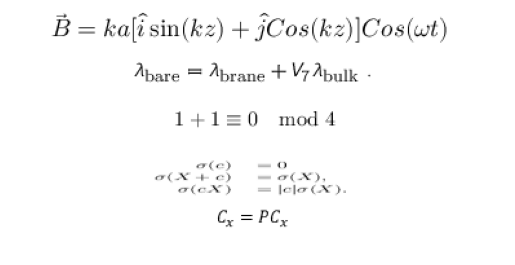

In [5]:
def sample_image():
    fname = fnames.sample().values[0]
    img = cv2.imread(os.path.join(STACKED_FORMULAE_PATH, fname))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    return img

_ = sample_image()

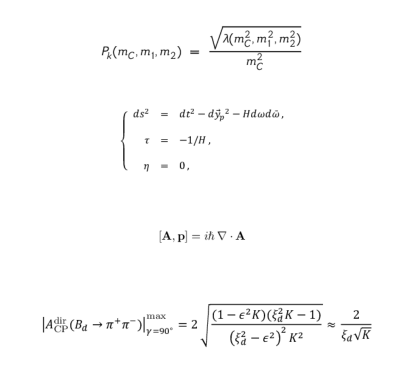

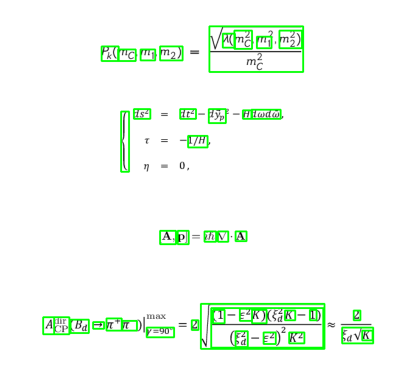

In [87]:
def split_lines(img):
    """
    Identify portions of the image that contain blank spaces 
    inbetween lines
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilate = cv2.dilate(thresh, kernel, iterations=2)
    contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lines = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 10 and h > 10:
            lines.append((x, y, w, h))
    return lines


def plot_lines(img, lines):
    """
    Plot the identified lines on the image
    """
    img = img.copy()
    for x, y, w, h in lines:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


img = sample_image()
lines = split_lines(img)
plot_lines(img, lines)

In [89]:
img.shape
img.sum(2).shape

(608, 652)

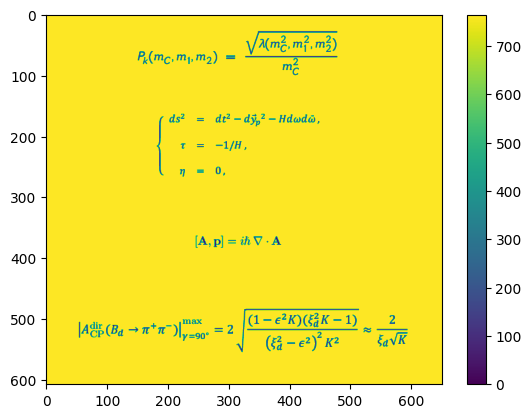

In [90]:
x = img.sum(2)
plt.imshow(x)
plt.colorbar()

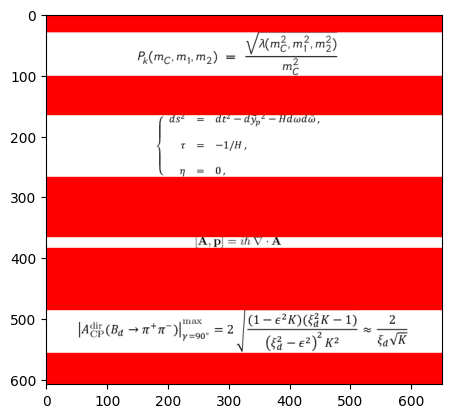

In [91]:
yblanks = np.argwhere(x.min(1) == 255*3).flatten()

plt.imshow(img)
for y in yblanks:
    plt.axhline(y, color="r", lw=1)

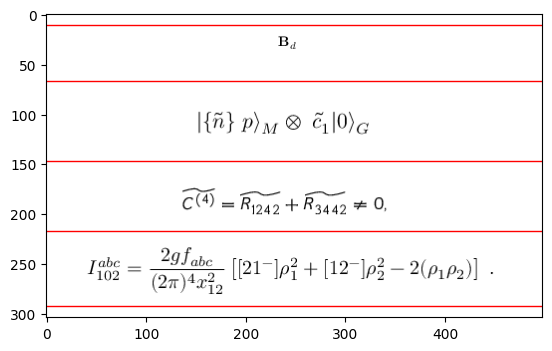

In [44]:
def find_blank_space(img, threshold=255):
    """
    Spot longitudinal blank spaces in the image
    """

    x = img.sum(2)
    yblanks = np.argwhere(x.min(1) == threshold*3).flatten()
    return yblanks

def find_filled_spaces(img):
    """
    Spot longitudinal filled spaces in the image
    """
    x = img.sum(2)
    yfilled = np.argwhere(x.min(1) < 255*3).flatten()
    return yfilled

def aggregate_vertical_indices(yblanks):
    """
    Given a list of vertical indices, aggregate them into
    single lines where they are contiguous
    """
    yblanks = np.sort(yblanks)
    yblanks = np.split(yblanks, np.where(np.diff(yblanks) > 1)[0] + 1)
    return [np.mean(yblank).astype(int) for yblank in yblanks]

agg_blanks = aggregate_vertical_indices(find_blank_space(img))

plt.imshow(img)
for y in agg_blanks:
    plt.axhline(y, color="r", lw=1)

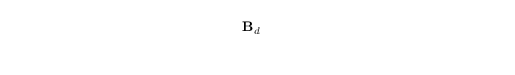

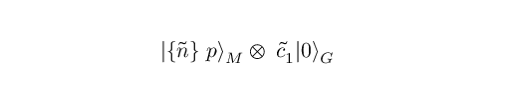

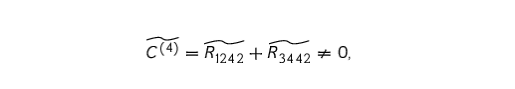

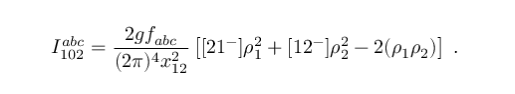

In [46]:
def split_img_into_lines(img, threshold=255):
    """
    Given a multiline image, comupute blank line separators
    and return the resulting line formulas in a list
    """
    yblanks = find_blank_space(img, threshold=threshold)
    agg_blanks = aggregate_vertical_indices(yblanks)
    lines = []
    for i, yblank in enumerate(agg_blanks):
        if i == 0:
            continue
        line = img[agg_blanks[i-1]:yblank]
        lines.append(line)
    return lines

formulas = split_img_into_lines(img)

for formula in formulas:
    plt.imshow(formula)
    plt.axis("off")
    plt.show()

In [47]:
# Cut exceeding white space in the sides of a formula image
def cut_white_space(img):
    """
    Cut exceeding white space in the sides of a formula image
    """
    x = img.sum(2)
    x = x.min(0)
    x = np.where(x < 255*3)[0]
    if len(x) == 0:
        return img
    x0, x1 = x[0], x[-1]
    return img[:, x0:x1]


# Test Evaluation

In [22]:
from pix2tex.dataset.transforms import test_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


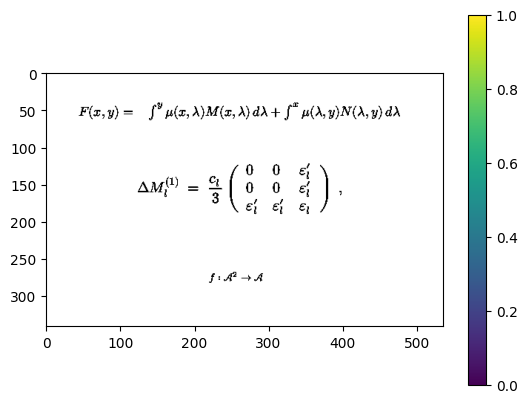

In [54]:
img_path = fnames.sample().values[0]

img = cv2.imread(os.path.join(STACKED_FORMULAE_PATH, img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
timg = test_transform(image=img)["image"]

plt.imshow(timg.permute(1, 2, 0).numpy())
plt.colorbar()

In [60]:
# find percentile distirbutions of the image
pd.Series(timg.flatten()).describe(percentiles=np.arange(0, 1, 0.1))

count    549936.000000
mean          1.136818
std           0.449890
min          -4.563291
0%           -4.563291
10%           1.190449
20%           1.190449
30%           1.190449
40%           1.190449
50%           1.190449
60%           1.190449
70%           1.190449
80%           1.190449
90%           1.190449
max           1.190449
dtype: float64

In [42]:
img.shape

(304, 498, 3)

In [41]:
timg.shape

torch.Size([3, 304, 498])

In [63]:
import torch

In [61]:
# test preprocessing on tensor

# split in formulas
formulas = split_img_into_lines(timg.permute(1, 2, 0).numpy(), threshold=0)

for formula in formulas:
    plt.imshow(formula)
    plt.axis("off")
    plt.show()

/Users/juansegundohevia/anaconda3/envs/pix2text/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/juansegundohevia/anaconda3/envs/pix2text/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/2c/s1dc7gqn0jz4dls2kprq822m0000gn/T/ipykernel_7543/84035149.py:25: RuntimeWarning: invalid value encountered in cast
  return [np.mean(yblank).astype(int) for yblank in yblanks]


In [ ]:
def find_blank_space(img, threshold=255):
    """
    Spot longitudinal blank spaces in the image
    """

    x = img.sum(2)
    yblanks = np.argwhere(x.min(1) == threshold*3).flatten()
    return yblanks

def find_filled_spaces(img):
    """
    Spot longitudinal filled spaces in the image
    """
    x = img.sum(2)
    yfilled = np.argwhere(x.min(1) < 255*3).flatten()
    return yfilled

def aggregate_vertical_indices(yblanks):
    """
    Given a list of vertical indices, aggregate them into
    single lines where they are contiguous
    """
    yblanks = np.sort(yblanks)
    yblanks = np.split(yblanks, np.where(np.diff(yblanks) > 1)[0] + 1)
    return [np.mean(yblank).astype(int) for yblank in yblanks]

agg_blanks = aggregate_vertical_indices(find_blank_space(img))

plt.imshow(img)
for y in agg_blanks:
    plt.axhline(y, color="r", lw=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


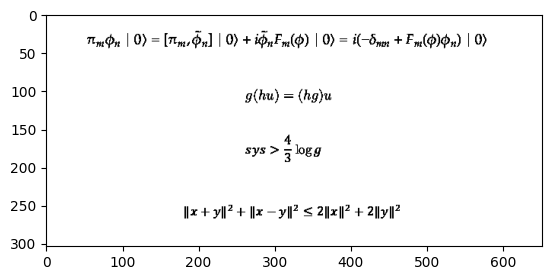

In [128]:
class ImageTensor:

    def __init__(self, tensor, th=255):
        self.arr = tensor.permute(1,2,0).numpy()
        self.th = th


    def find_blank_space(self):
        """
        Spot longitudinal blank spaces in the image
        """

        x = self.arr.sum(2)
        yblanks = np.argwhere(x.min(1) > self.th*3).flatten()
        self.yblanks = yblanks

    def find_filled_spaces(self):
        """
        Spot longitudinal filled spaces in the image
        """
        x = self.arr.sum(2)
        yfilled = np.argwhere(x.min(1) > self.th*3).flatten()
        self.yfilled = yfilled

    def aggregate_vertical_indices(self):
        """
        Given a list of vertical indices, aggregate them into
        single lines where they are contiguous
        """
        yblanks = np.sort(self.yblanks)
        yblanks = np.split(yblanks, np.where(np.diff(yblanks) > 1)[0] + 1)
        return [np.mean(yblank).astype(int) for yblank in yblanks]

    def split_img_into_lines(self):
        """
        Given a multiline image, comupute blank line separators
        and return the resulting line formulas in a list
        """
        self.find_blank_space()
        agg_blanks = self.aggregate_vertical_indices()
        lines = []
        for i, yblank in enumerate(agg_blanks):
            if i == 0:
                continue
            line = self.arr[agg_blanks[i-1]:yblank]
            lines.append(line)
        return lines


new_img_path = fnames.sample().values[0]
img = cv2.imread(os.path.join(STACKED_FORMULAE_PATH, new_img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
trans_img = test_transform(image=img)["image"]
plt.imshow(trans_img.permute(1, 2, 0))

In [133]:
img_tensor = ImageTensor(trans_img, th=1)
formulas = img_tensor.split_img_into_lines()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


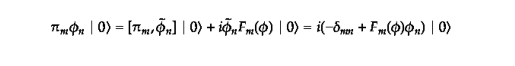

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


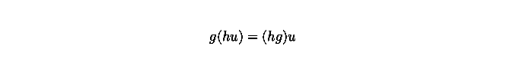

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


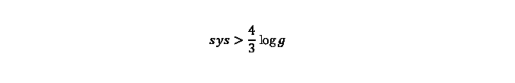

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


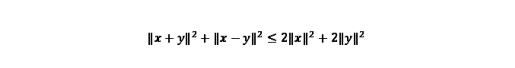

In [134]:
for formula in formulas:
    plt.imshow(formula)
    plt.axis("off")
    plt.show()